In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.mplot3d
import mpl_toolkits.axes_grid1 as plt_ax
import itertools
%matplotlib inline

In [12]:
def plot(ax, data, enum=False, title='', labels=None, legend=False, **kwargs):
    plotted = None
    if enum:
        plotted = ax.plot(data)
    else:
        mapping = np.array(data).T
        plotted = ax.plot(mapping[0], mapping[1], **kwargs)
    if labels:
        ax.set_xlabel(labels[0])
        if (len(labels) > 1):
            ax.set_ylabel(labels[1])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ax.set_title(title)
    ax.grid(True)
    return plotted

def scatter(ax, data, enum=False, title='', labels=None, legend=False, **kwargs):
    scattered = None
    if enum:
        scattered = ax.scatter(range(len(data)), data, **kwargs)
    else:
        mapping = np.array(data).T
        scattered = ax.scatter(mapping[0], mapping[1], **kwargs)
    if labels:
        ax.set_xlabel(labels[0])
        if (len(labels) > 1):
            ax.set_ylabel(labels[1])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ax.set_title(title)
    ax.grid(True)
    ax.scatter(*np.mean(data, axis=0), color='red', s=40)
    return scattered

def plot_ridge(ridge):
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(*ridge.T)
    ax1.set_xticks(ax1.get_xticks()[::2])
    ax1.set_yticks(ax1.get_yticks()[::2])
    ax1.set_zticks(ax1.get_zticks()[::2])
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_zlabel('y')
    ax1.scatter(*ridge.mean(axis=0), color='red', s=70)
    ax2 = fig.add_subplot(132)
    scatter(ax2, ridge[:, [0, 2]], labels=['x1', 'y'])
    ax2.set_xticks(ax2.get_xticks()[::2])
    ax3 = fig.add_subplot(133)
    scatter(ax3, ridge[:, [1, 2]], labels=['x2', 'y'])
    fig.tight_layout()

def scatter_set(data1, data2, titles=['Training set', 'Validation set']):
    min_ = min(np.concatenate([data1[:, 2], data2[:, 2]]))
    max_ = max(np.concatenate([data1[:, 2], data2[:, 2]]))
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    for data, ax, title in zip([data1, data2], axes, titles):
        dataX = data[:, :2]
        dataY = data[:, 2]
        C = dataX.T.dot(dataX) / dataX.shape[0]
        _, ev = np.linalg.eigh(C)
        scatter_ax = scatter(ax, dataX, c=dataY, vmin=min_, vmax=max_, s=np.sqrt(dataY / max_) * 100, title=title)
        ax.arrow(0, 0, *ev[0], head_width=0.2, head_length=0.1, fc='k', ec='k')
        ax.arrow(0, 0, *ev[1], head_width=0.2, head_length=0.1, fc='k', ec='k')
    fig.subplots_adjust(right=0.85)
    fig.colorbar(scatter_ax, cmap='jet', cax=fig.add_axes([0.9, 0.15, 0.03, 0.7]))
    
def plot_heatmaps(monomials):
    powers = np.array([[0, 0], [1, 0], [0, 1], [2, 0], [1, 1], [0, 2], [3, 0], [2, 1], [1, 2], [0, 3]])
    fig, axes = plt.subplots(5, 2, figsize=(10, 16))
    for row, axesRow in enumerate(axes):
        for col, ax in enumerate(axesRow):
            i = row * 2 + col
            max_ = 5  # monomials[i, :10].max()
            img = ax.imshow(monomials[i, :10].T, extent=[-40, 40, -35, 35], aspect='auto', vmin=-max_, vmax=max_)
            cax = plt_ax.make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
            cbar = plt.colorbar(img, cax=cax)
            ax.set_title(r'$degree = {}, \phi_{} = x_1^{} x_2^{}$'.format(powers[i].sum(), i, *powers[i]))
            ax.set_ylabel('x1')
            ax.set_xlabel('x2')
    fig.subplots_adjust(hspace=.4, wspace=.3)

def plot_mse(MSE, lambda_index='T'):
    fig, ax = plt.subplots(1, 1, figsize=(13, 4))
    meanlineprops = dict(linestyle='--', linewidth=2.5, color='green')
    ax.boxplot(MSE.T, meanprops=meanlineprops, meanline=True, showmeans=True)
    ax.set_yscale('log')
    means = MSE.T.mean(axis=0)
    best_mse_index = np.argmin(means)
    ax.set_title(r'Boxplots for each lambda  -  $avg_{{min}} = {:.2f}$ at $\lambda_{} = 10^{{{:.1f}}}$'.format(
        means[best_mse_index], lambda_index, np.linspace(-4, 4, 81)[best_mse_index]))
    ax.grid(True)
    ax.set_xticks(ax.get_xticks()[::10])
    ax.set_xticklabels([r'$10^{{{}}}$'.format(x) for x in range(-4, 5)])

In [2]:
train_data = np.genfromtxt("TrainingRidge.csv", delimiter=',')
val_data = np.genfromtxt("ValidationRidge.csv", delimiter=',')

In [3]:
X_train = train_data[1:, :2]
y_train = train_data[1:, -1]

X_val = val_data[1:, :2]
y_val = val_data[1:, -1]

In [4]:
def sphering(X, X_val):
    
    # Center data
    X_centered = X - np.mean(X, axis=0)
    X_centered = X_centered.T

    # Calculating the covariance matrix
    X_cov = np.cov(X_centered, rowvar=True)

    # Using np.linalg.eig function
    w, v = np.linalg.eig(X_cov)
    
    # Calculate inverse square root of Eigenvalues
    diagw = np.diag(1/(w**0.5))

    # Sphering training data 
    Xt_sphered = np.dot(np.dot(diagw, v.T), X_centered)  

    # sphering val data

    Xv_sphered = np.dot(np.dot(diagw, v.T), (X_val.T - np.mean(X)))
    
    return Xt_sphered, Xv_sphered

In [13]:
Xt_sphered, Xv_sphered = sphering(X_train, X_val)
Xt_sphered = Xt_sphered.T
Xv_sphered = Xv_sphered.T

print(f"Mean: {np.mean(Xt_sphered)}")
print(f"Variance: {np.var(Xt_sphered)}")

print(f"Mean: {np.mean(Xv_sphered)}")
print(f"Variance: {np.var(Xv_sphered)}")

Mean: 3.3306690738754696e-16
Variance: 0.9949999999999999
Mean: -0.5128951026718833
Variance: 5.966671885711993


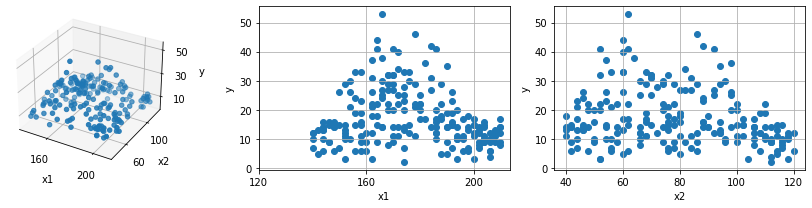

In [15]:
plot_ridge(train_data)

(200, 3)


<ipython-input-12-647f6fcb4e2f>:67: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(scatter_ax, cmap='jet', cax=fig.add_axes([0.9, 0.15, 0.03, 0.7]))


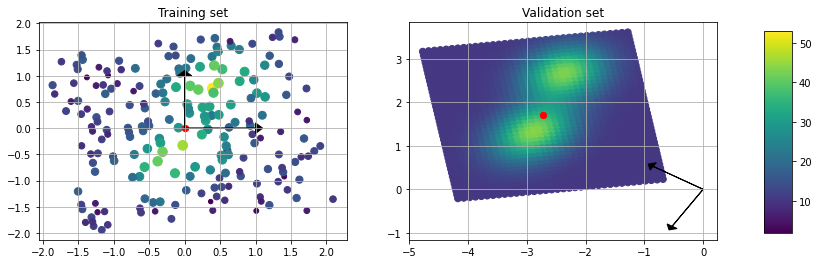

In [16]:
data1 = np.c_[Xt_sphered, y_train]
data2 = np.c_[Xv_sphered, y_val]
print(data1.shape)
scatter_set(data1, data2)